Import Libraries

Data

In [3]:
train=pd.read_csv(train_path)
test=pd.read_csv(test_path)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# Initialize processor
processor = HousingDataProcessor(train)

In [7]:
processed_df = processor.run_full_pipeline()


RUNNING FULL DATA PROCESSING PIPELINE

[1/9] Analyzing missing values...
MISSING VALUE ANALYSIS

Low (<5%):
  BsmtExposure: 2.60%
  BsmtFinType2: 2.60%
  BsmtQual: 2.53%
  BsmtCond: 2.53%
  BsmtFinType1: 2.53%
  MasVnrArea: 0.55%
  Electrical: 0.07%

Medium (5-25%):
  LotFrontage: 17.74%
  GarageType: 5.55%
  GarageYrBlt: 5.55%
  GarageFinish: 5.55%
  GarageQual: 5.55%
  GarageCond: 5.55%

High (>25%):
  PoolQC: 99.52%
  MiscFeature: 96.30%
  Alley: 93.77%
  Fence: 80.75%
  MasVnrType: 59.73%
  FireplaceQu: 47.26%

✓ Missing values handled. Remaining nulls: 0

[2/9] Detecting outliers...

OUTLIER DETECTION REPORT
MSSubClass: 103 outliers (7.05%)
LotFrontage: 93 outliers (6.37%)
LotArea: 69 outliers (4.73%)
OverallQual: 2 outliers (0.14%)
OverallCond: 125 outliers (8.56%)
YearBuilt: 7 outliers (0.48%)
MasVnrArea: 98 outliers (6.71%)
BsmtFinSF1: 7 outliers (0.48%)
BsmtFinSF2: 167 outliers (11.44%)
BsmtUnfSF: 29 outliers (1.99%)
TotalBsmtSF: 61 outliers (4.18%)
1stFlrSF: 20 outliers (1.3

In [14]:
# Prepare data
X = processed_df.drop(['SalePrice'], axis=1)
y = processed_df['SalePrice']


In [16]:
# Initialize and run full pipeline

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False

pipeline = HousingModelingPipeline(X, y, test_size=0.2)
results = pipeline.run_full_pipeline()

Data split: 1168 training samples, 292 test samples

RUNNING FULL MODELING PIPELINE

[1/7] Fitting baseline models...

NAIVE BASELINE MODELS

1. Mean Prediction
   Prediction: $181,441.54 for all homes
   RMSE: $87,619.03
   MAE: $62,575.93

2. Median Prediction
   Prediction: $165,000.00 for all homes
   RMSE: $88,667.17
   MAE: $59,568.25

3. Neighborhood Median
   RMSE: $58,125.32
   MAE: $37,202.98
   Improvement over mean: 33.7%

[2/7] Fitting linear regression...

LINEAR REGRESSION

Linear Regression Performance:
  RMSE: $33,785.76 (21.9% of median price)
  MAE: $20,819.53
  R²: 0.8512
  MAPE: 12.69%
  Rating: Needs Improvement

Top 10 Features:
  1stFlrSF_Capped: $92,654.83
  1stFlrSF: $-67,184.15
  Has_Garage: $-52,200.08
  GrLivArea_Capped: $52,175.33
  2ndFlrSF: $47,005.53
  TotRmsAbvGrd: $-34,219.02
  OverallQual: $32,195.15
  TotalSF_Capped: $-31,717.34
  AvgRoomSize: $-29,912.60
  GarageYrBlt: $25,358.50

[3/7] Fitting regularized models...

REGULARIZED LINEAR MODELS

1. R

In [17]:
# Analyze best model
residuals = pipeline.analyze_residuals('xgboost')
shap_values = pipeline.get_feature_importance_shap('xgboost')


RESIDUAL ANALYSIS: xgboost

Residual Statistics:
  Mean: $235.32
  Std Dev: $26,718.20
  Min: $-113,437.09
  Max: $163,455.12

Normality Test (Shapiro-Wilk):
  p-value: 0.0000
  Result: Residuals deviate from normal distribution

SHAP ANALYSIS: xgboost
Calculating SHAP values for 100 samples...

Top 10 Features by SHAP:
  OverallQual: 13486.8262
  TotalSF: 12654.1700
  TotalSF_Capped: 7755.9456
  YearBuilt: 7351.7325
  QualityScore: 4708.5250
  TotalBath: 3824.4881
  YearRemodAdd: 3445.1872
  GarageCars: 2772.6303
  BsmtFinSF1: 2523.6073
  Fireplaces: 2030.0594


Calculate accuracy percentages within 5% and 10% thresholds

In [18]:
# 1. Accuracy Analysis
y_test = pipeline.y_test
y_pred_xgb = pipeline.predictions['xgboost']

# Calculate absolute percentage errors
pct_errors = np.abs((y_test - y_pred_xgb) / y_test)

# Calculate accuracy metrics
acc_5pct = (pct_errors <= 0.05).mean() * 100
acc_10pct = (pct_errors <= 0.10).mean() * 100

print("=" * 60)
print("BUSINESS KPI ASSESSMENT (XGBoost)")
print("=" * 60)
print(f"Predictions within 10% of actual price: {acc_10pct:.2f}%")
print(f"Predictions within 5% of actual price:  {acc_5pct:.2f}%")

BUSINESS KPI ASSESSMENT (XGBoost)
Predictions within 10% of actual price: 71.23%
Predictions within 5% of actual price:  40.75%


Simulate a renovation scenario (improving Overall Quality) for a sample property, update dependent features, and calculate the potential ROI.
I will select a sample property, simulate a renovation by updating quality features, and calculate the ROI based on the XGBoost model's predictions.

In [20]:
# Renovation ROI Simulator

# 1. Identify a sample property (Average home, OverallQual=5 or 6)
X_test_numeric = pipeline.X_test.select_dtypes(include=[np.number])
sample_idx = X_test_numeric[(X_test_numeric['OverallQual'] >= 5) &
                              (X_test_numeric['OverallQual'] <= 6)].index[0]

# Extract as DataFrame to keep column names
original_home = X_test_numeric.loc[[sample_idx]].copy()

# 2. Define renovation cost
renovation_cost = 20000

# 3. Create renovated copy
renovated_home = original_home.copy()

# 4. Improve quality
old_qual = original_home['OverallQual'].iloc[0]
new_qual = old_qual + 1
renovated_home['OverallQual'] = new_qual

# 5. Update dependent engineered features
# Update QualityScore = OverallQual * OverallCond
if 'QualityScore' in renovated_home.columns:
    renovated_home['QualityScore'] = renovated_home['OverallQual'] * renovated_home['OverallCond']

# Update QualPerSF = OverallQual / (GrLivArea / 1000)
if 'QualPerSF' in renovated_home.columns and 'GrLivArea' in renovated_home.columns:
    renovated_home['QualPerSF'] = renovated_home['OverallQual'] / (renovated_home['GrLivArea'] / 1000)

# 6. Predict prices
# Ensure input shape matches training (pipeline handles scaling/selection if built-in,
# but here we are accessing the model directly which expects numeric inputs as per previous steps)
pred_original = pipeline.models['xgboost'].predict(original_home)[0]
pred_renovated = pipeline.models['xgboost'].predict(renovated_home)[0]

# 7. Calculate ROI
value_added = pred_renovated - pred_original
roi = (value_added - renovation_cost) / renovation_cost * 100

# 8. Generate Report
print("=" * 60)
print("RENOVATION ROI SIMULATOR")
print("=" * 60)
print(f"Property ID: {sample_idx}")
print(f"Renovation: Increase Overall Quality from {old_qual} to {new_qual}")
print(f"Estimated Cost: ${renovation_cost:,.2f}")
print("-" * 60)
print(f"Original Estimated Value:  ${pred_original:,.2f}")
print(f"Renovated Estimated Value: ${pred_renovated:,.2f}")
print(f"Value Added:               ${value_added:,.2f}")
print("-" * 60)
print(f"Return on Investment (ROI): {roi:.2f}%")

if roi > 0:
    print("Recommendation: Proceed with renovation (Positive ROI)")
else:
    print("Recommendation: Do not proceed (Negative ROI)")

RENOVATION ROI SIMULATOR
Property ID: 892
Renovation: Increase Overall Quality from 6 to 7
Estimated Cost: $20,000.00
------------------------------------------------------------
Original Estimated Value:  $136,568.19
Renovated Estimated Value: $148,507.81
Value Added:               $11,939.62
------------------------------------------------------------
Return on Investment (ROI): -40.30%
Recommendation: Do not proceed (Negative ROI)


Analyze the validation set to identify 'undervalued' and 'overpriced' properties based on the difference between predicted and actual prices.
Create a market opportunities analysis by comparing predicted values against actual sales prices to identify potential undervalued and overpriced assets.

In [21]:
# 1. Create Market Opportunities DataFrame
market_opportunities = pipeline.X_test.copy()
market_opportunities['Actual'] = pipeline.y_test
market_opportunities['Predicted'] = pipeline.predictions['xgboost']

# 2. Calculate differences
# Diff_Value = Predicted - Actual (Positive means model values it higher -> Potential Bargain/Undervalued)
market_opportunities['Diff_Value'] = market_opportunities['Predicted'] - market_opportunities['Actual']
market_opportunities['Diff_Pct'] = (market_opportunities['Diff_Value'] / market_opportunities['Actual']) * 100

# 3. Filter Undervalued (Predicted > Actual by > 15%)
# These are properties selling for significantly less than the model thinks they are worth
undervalued = market_opportunities[market_opportunities['Diff_Pct'] > 15].sort_values('Diff_Pct', ascending=False)

# 4. Filter Overpriced (Predicted < Actual by < -15%)
# These are properties selling for significantly more than the model thinks they are worth
overpriced = market_opportunities[market_opportunities['Diff_Pct'] < -15].sort_values('Diff_Pct', ascending=True)

# 5. Summary Report
print("=" * 60)
print("MARKET OPPORTUNITIES ANALYSIS")
print("=" * 60)
print(f"Total Validation Samples: {len(market_opportunities)}")
print(f"Undervalued Opportunities (>15% potential upside): {len(undervalued)}")
print(f"Overpriced Listings (<-15% potential downside):    {len(overpriced)}")

# 6. Display Details
cols_to_show = ['Neighborhood', 'GrLivArea', 'OverallQual', 'YearBuilt', 'Actual', 'Predicted', 'Diff_Value', 'Diff_Pct']
available_cols = [c for c in cols_to_show if c in market_opportunities.columns]

print("\nTop 5 Undervalued Properties (Potential Buys):")
print(undervalued[available_cols].head(5).to_string(formatters={
    'Actual': '${:,.2f}'.format,
    'Predicted': '${:,.2f}'.format,
    'Diff_Value': '${:,.2f}'.format,
    'Diff_Pct': '{:.2f}%'.format
}))

print("\nTop 5 Overpriced Properties (Potential Sells/Avoid):")
print(overpriced[available_cols].head(5).to_string(formatters={
    'Actual': '${:,.2f}'.format,
    'Predicted': '${:,.2f}'.format,
    'Diff_Value': '${:,.2f}'.format,
    'Diff_Pct': '{:.2f}%'.format
}))

MARKET OPPORTUNITIES ANALYSIS
Total Validation Samples: 292
Undervalued Opportunities (>15% potential upside): 29
Overpriced Listings (<-15% potential downside):    20

Top 5 Undervalued Properties (Potential Buys):
     Neighborhood  GrLivArea  OverallQual  YearBuilt      Actual   Predicted Diff_Value Diff_Pct
30         IDOTRR       1317            4       1920  $40,000.00  $93,088.10 $53,088.10  132.72%
916        IDOTRR        480            2       1949  $35,311.00  $71,404.45 $36,093.45  102.22%
812        IDOTRR       1044            5       1952  $55,993.00 $100,635.26 $44,642.26   79.73%
1432      OldTown        968            4       1927  $64,500.00 $110,121.09 $45,621.09   70.73%
588       ClearCr       1473            5       1968 $143,000.00 $235,974.80 $92,974.80   65.02%

Top 5 Overpriced Properties (Potential Sells/Avoid):
     Neighborhood  GrLivArea  OverallQual  YearBuilt      Actual   Predicted   Diff_Value Diff_Pct
218       Crawfor       1954            7       1

In [22]:
# 1. Create a subset of the validation data containing only numeric features
X_test_numeric = pipeline.X_test.select_dtypes(include=[np.number])

# 2. Initialize a SHAP TreeExplainer with the trained XGBoost model
explainer = shap.TreeExplainer(pipeline.models['xgboost'])

# 3. Compute the SHAP values for the numeric validation dataset
shap_values_val = explainer.shap_values(X_test_numeric)

# 4. Store variables for later use
# shap_values_val is a numpy array of SHAP values
print(f"SHAP values shape: {shap_values_val.shape}")

SHAP values shape: (292, 73)


SHAP SUMMARY PLOT


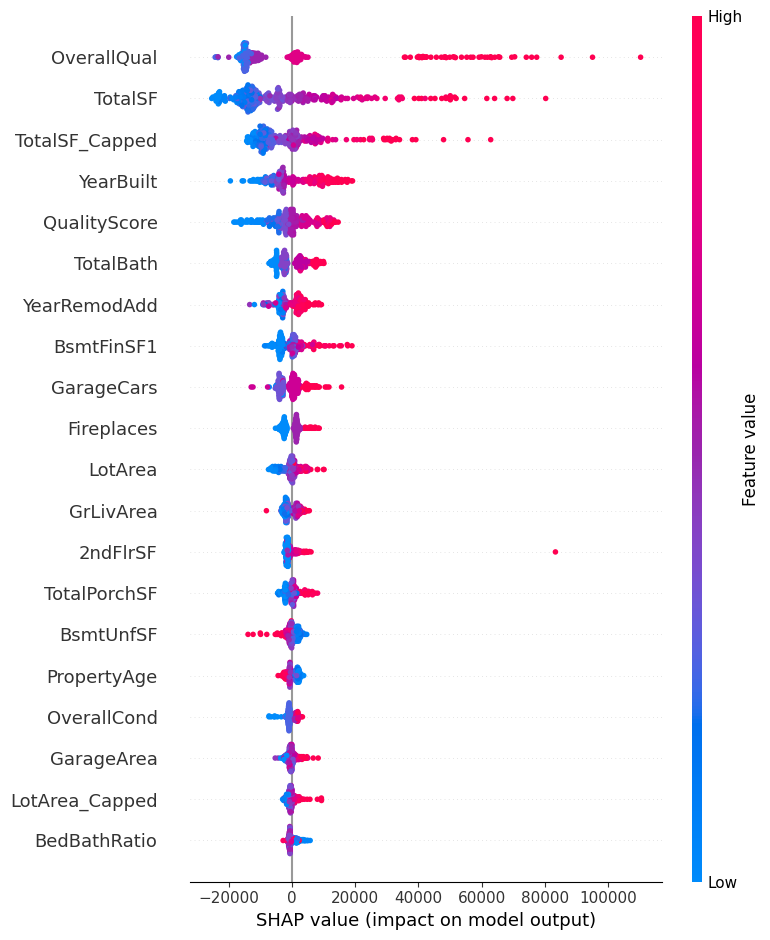

In [24]:
import matplotlib.pyplot as plt

print("=" * 60)
print("SHAP SUMMARY PLOT")
print("=" * 60)

# Generate SHAP beeswarm summary plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_val, X_test_numeric, show=True)
plt.show()

Analyze a specific sample property to break down its prediction into base value and feature contributions.
I will select a sample, retrieve its SHAP values and the model's base value, calculate the final prediction, and print a detailed breakdown of the top contributing features.

In [32]:
# 1. Select a specific sample
sample_idx = 32
sample_feature_values = X_test_numeric.iloc[sample_idx]
sample_shap_values = shap_values_val[sample_idx]

# 2. Get the model's base value
# TreeExplainer.expected_value is usually a single float for regression
base_value = explainer.expected_value

# 3. Calculate final prediction from SHAP
# Prediction = Base Value + Sum(SHAP values)
total_shap_impact = np.sum(sample_shap_values)
final_prediction_shap = base_value + total_shap_impact

# 4. Create a DataFrame of feature impacts for this sample
impact_df = pd.DataFrame({
    'Feature': X_test_numeric.columns,
    'Feature Value': sample_feature_values.values,
    'SHAP Value': sample_shap_values,
    'Abs Impact': np.abs(sample_shap_values)
}).sort_values('Abs Impact', ascending=False)

# 5. Print Prediction Breakdown
print("=" * 60)
print(f"PREDICTION BREAKDOWN (Sample Index: {X_test_numeric.index[sample_idx]})")
print("=" * 60)
print(f"Base value (average):     ${base_value:,.2f}")
print(f"Total Feature impacts:    ${total_shap_impact:,.2f}")
print("-" * 60)
print(f"Final Prediction:         ${final_prediction_shap:,.2f}")

print("\nTop 5 Contributing Features:")
for i, row in impact_df.head(5).iterrows():
    impact_str = f"+${row['SHAP Value']:,.2f}" if row['SHAP Value'] > 0 else f"-${abs(row['SHAP Value']):,.2f}"
    print(f"  {row['Feature']} ({row['Feature Value']}): {impact_str}")

PREDICTION BREAKDOWN (Sample Index: 1173)
Base value (average):     $181,164.70
Total Feature impacts:    $24,492.06
------------------------------------------------------------
Final Prediction:         $205,656.77

Top 5 Contributing Features:
  TotalSF (4684.0): +$38,744.67
  TotalSF_Capped (4684.0): +$29,691.36
  OverallQual (5.0): -$23,400.76
  YearBuilt (1946.0): -$8,480.10
  QualityScore (30.0): -$8,030.55
